In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as f

layers = [4 * 4, 8, 8, 10]  # Update layer sizes for 4x4 input


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(layers[0], layers[1])
        self.fc2 = nn.Linear(layers[1], layers[2])
        self.fc3 = nn.Linear(layers[2], layers[3])

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def predict(ffnn_model, image):
    with torch.no_grad():
        logits = ffnn_model(image)
        predicted = torch.argmax(logits, dim=1)
        return predicted

In [12]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Grayscale(),  # Convert RGB to 1-channel
    transforms.Resize((4, 4)),  # Resize to 4x4
    transforms.ToTensor()
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


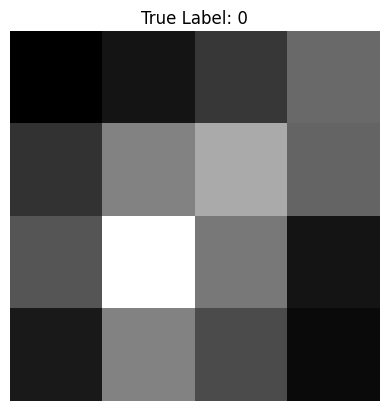

Predicted Label: 5


In [13]:
model = Classifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    print(f"Epoch {epoch + 1}")
    for images, labels in train_loader:
        output = model(images)
        loss = loss_fn(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

import matplotlib.pyplot as plt

# Get one test image and label
test_img, test_label = test_data[10]
plt.imshow(test_img.squeeze(), cmap='gray')
plt.title(f"True Label: {test_label}")
plt.axis('off')
plt.show()

# Model prediction
model.eval()
test_img_input = test_img.unsqueeze(0)  # Add batch dimension
pred = predict(model, test_img_input)
print(f"Predicted Label: {pred.item()}")

In [14]:
from z3 import *
from z3 import If


def encode_nn_with_smt(input_image, model_weights, perturbation_bound, timeout=10000):
    def R(x):
        return RealVal(x)

    # Define input variables with perturbation constraints
    input_vars = [Real(f'x_{i}') for i in range(layers[0])]
    perturbed_vars = [Real(f'x_perturbed_{i}') for i in range(layers[0])]
    constraints = []

    print("Defining constraints for input variables")
    for i in range(layers[0]):
        constraints.append(input_vars[i] == R(input_image[i]))
        constraints.append(perturbed_vars[i] >= 0)
        constraints.append(perturbed_vars[i] <= 1)  # Assuming normalized input

    # L2-norm perturbation constraint
    diff_squares = [ (perturbed_vars[i] - input_vars[i]) * (perturbed_vars[i] - input_vars[i])
                     for i in range(layers[0]) ]
    constraints.append(Sum(diff_squares) <= R(perturbation_bound ** 2))

    print("Added input variable constraints")
    # Encode the first layer: y1 = ReLU(W1 * x + b1)
    W1, b1 = model_weights['fc1']
    y1 = [Real(f'y1_{i}') for i in range(layers[1])]
    for i in range(layers[1]):
        linear_expr = Sum([R(round(W1[i][j], 5)) * perturbed_vars[j] for j in range(layers[0])]) + R(round(b1[i], 5))
        constraints.append(y1[i] == If(linear_expr > 0, linear_expr, 0))

    print("Added first layer constraints")
    # Encode the second layer: y2 = ReLU(W2 * y1 + b2)
    W2, b2 = model_weights['fc2']
    y2 = [Real(f'y2_{i}') for i in range(layers[2])]
    for i in range(layers[2]):
        linear_expr = Sum([R(round(W2[i][j], 5)) * y1[j] for j in range(layers[1])]) + R(round(b2[i], 5))
        constraints.append(y2[i] == If(linear_expr > 0, linear_expr, 0))

    print("Added second layer constraints")
    # Encode the third layer: y3 = W3 * y2 + b3
    W3, b3 = model_weights['fc3']
    y3 = [Real(f'y3_{i}') for i in range(layers[3])]
    for i in range(layers[3]):
        linear_expr = Sum([R(round(W3[i][j], 5)) * y2[j] for j in range(layers[2])]) + R(round(b3[i], 5))
        constraints.append(y3[i] == linear_expr)

    print("Added third layer constraints")
    # Encode ArgMax: Ensure the predicted class remains the same
    predicted_class = model_weights['predicted_class']
    for i in range(10):
        if i != predicted_class:
            constraints.append(y3[predicted_class] >= y3[i])

    print("Added all constraints")

    with open("nn_encoding.smt2", "w") as smt_file:
        solver = Solver()
        solver.add(constraints)
        smt_file.write(solver.to_smt2())
    print("SMT encoding written to nn_encoding.smt2")

    # Print size of SMT problem
    print(f"Number of constraints: {len(constraints)}")
    print(f"Number of variables: {len(input_vars) + len(perturbed_vars) + len(y1) + len(y2)} (4x4 input)")

    # Solve the constraints
    solver = Solver()
    solver.set("timeout", timeout)
    solver.add(constraints)
    print("Solving...")
    result = solver.check()
    print(f"Result: {result}")
    if result == sat:
        print("SAT: Perturbation within bounds")
    elif result == unsat:
        print("UNSAT: Perturbation exceeds bounds")
    else:
        print("UNKNOWN: Solver could not determine satisfiability")


In [19]:
print("Loading CIFAR10 test dataset")
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
test_image, test_label = next(iter(test_loader))  # Get one test image and label
test_image = test_image.view(-1, 4 * 4)  # Flatten the image

print("Extracting model weights and biases")
model.eval()
fc1_weights = model.fc1.weight.detach().tolist()
fc1_biases = model.fc1.bias.detach().tolist()
fc2_weights = model.fc2.weight.detach().tolist()
fc2_biases = model.fc2.bias.detach().tolist()
fc3_weights = model.fc3.weight.detach().tolist()
fc3_biases = model.fc3.bias.detach().tolist()

predicted_class = predict(model, test_image).item()
print(f"Predicted class for the test image: {predicted_class}")

model_weights = {
    'fc1': (fc1_weights, fc1_biases),
    'fc2': (fc2_weights, fc2_biases),
    'fc3': (fc3_weights, fc3_biases),
    'predicted_class': predicted_class
}

input_image = test_image.squeeze().tolist()  # Convert to a list
perturbation_bound = 0.01  # Example perturbation bound

print("Encoding the neural network with SMT solver")
encode_nn_with_smt(input_image, model_weights, perturbation_bound, 100000)

Loading CIFAR10 test dataset
Extracting model weights and biases
Predicted class for the test image: 6
Encoding the neural network with SMT solver
Defining constraints for input variables
Added input variable constraints
Added first layer constraints
Added second layer constraints
Added third layer constraints
Added all constraints
SMT encoding written to nn_encoding.smt2
Number of constraints: 84
Number of variables: 48 (4x4 input)
Solving...
Result: sat
SAT: Perturbation within bounds
